In [4]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBRegressor, plot_importance, XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

In [5]:
movie_path = "/content/tmdb_5000_movies.csv"

In [6]:
movie_df = pd.read_csv(movie_path)
movie_df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [7]:
movie_df.dtypes

,0
budget,int64
genres,object
homepage,object
id,int64
keywords,object
original_language,object
original_title,object
overview,object
popularity,float64
production_companies,object


In [8]:
movie_df.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000
mean,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,690.217989
std,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1234.585891
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,7.900000e+05,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000
50%,1.500000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000
75%,4.000000e+07,58610.500000,28.313505,9.291719e+07,118.000000,6.800000,737.000000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


<Axes: >

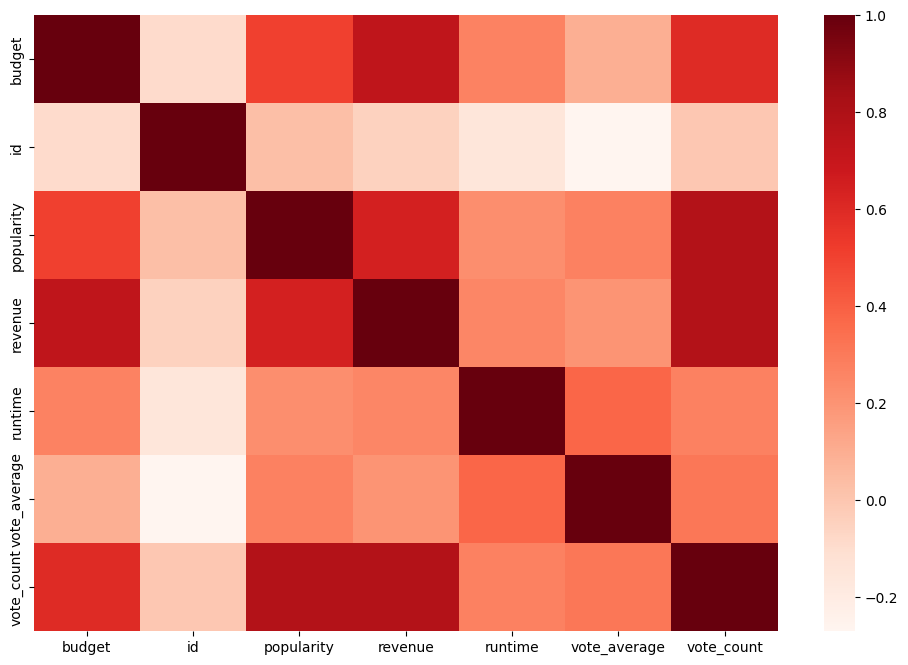

In [9]:
numeric_cols = movie_df.select_dtypes(include=np.number).columns
corr = movie_df[numeric_cols].corr()
fig, ax =plt.subplots(figsize=(12,8))
sns.heatmap(corr, cmap="Reds",
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        square=False   )

In [10]:
#Null Values

In [11]:
movie_df.apply(lambda x: sum(x.isna()),axis=0)

,0
budget,0
genres,0
homepage,3091
id,0
keywords,0
original_language,0
original_title,0
overview,3
popularity,0
production_companies,0


In [12]:
movie_df.loc[movie_df.runtime.isnull()]

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
2656,15000000,"[{""id"": 18, ""name"": ""Drama""}]",NaN,370980,"[{""id"": 717, ""name"": ""pope""}, {""id"": 5565, ""na...",it,Chiamatemi Francesco - Il Papa della gente,NaN,0.738646,"[{""name"": ""Taodue Film"", ""id"": 45724}]","[{""iso_3166_1"": ""IT"", ""name"": ""Italy""}]",2015-12-03,0,NaN,"[{""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,NaN,Chiamatemi Francesco - Il Papa della gente,7.3,12
4140,2,"[{""id"": 99, ""name"": ""Documentary""}]",NaN,459488,"[{""id"": 6027, ""name"": ""music""}, {""id"": 225822,...",en,"To Be Frank, Sinatra at 100",NaN,0.050625,"[{""name"": ""Eyeline Entertainment"", ""id"": 60343}]","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""}]",2015-12-12,0,NaN,[],Released,NaN,"To Be Frank, Sinatra at 100",0.0,0


In [13]:
movie_df['runtime'] = movie_df['runtime'].fillna(movie_df['runtime'].mean()) #setting null runtime values to mean runtime

In [14]:
movie_df.loc[movie_df.release_date.isnull()]

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
4553,0,[],NaN,380097,[],en,America Is Still the Place,1971 post civil rights San Francisco seemed li...,0.0,[],[],NaN,0,0.0,[],Released,NaN,America Is Still the Place,0.0,0


In [15]:
movie_df= movie_df.loc[movie_df.release_date.notnull()].copy()

In [16]:
movie_df['overview'] = movie_df['overview'].fillna("Unsepecified")

In [17]:
movie_df.apply(lambda x: sum(x==0),axis=0)

,0
budget,1036
genres,0
homepage,0
id,0
keywords,0
original_language,0
original_title,0
overview,0
popularity,0
production_companies,0


In [18]:
#Revenue and Budget

In [19]:
outlier_thresh=1000
movie_df=movie_df[movie_df.budget>outlier_thresh]
movie_df=movie_df[movie_df.revenue>outlier_thresh]
len(movie_df)

3211

In [20]:
zero_vals=movie_df.apply(lambda x: sum(x==0),axis=0)
zero_vals[zero_vals>0]

,0
vote_average,2
vote_count,2


In [21]:
movie_df=movie_df[movie_df.vote_count>0]

In [22]:
zero_vals=movie_df.apply(lambda x: sum(x==0),axis=0)
zero_vals[zero_vals>0]

,0


In [23]:
#JSON Handling

In [24]:
columns = ['genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages']

for col in columns:
    movie_df[col] = movie_df[col].apply(json.loads)

movie_df['release_date'] =  pd.to_datetime(movie_df['release_date'], format ='%Y-%m-%d')

In [25]:
movie_df['genres'][0]

[{'id': 28, 'name': 'Action'},
 {'id': 12, 'name': 'Adventure'},
 {'id': 14, 'name': 'Fantasy'},
 {'id': 878, 'name': 'Science Fiction'}]

In [26]:
movie_df['keywords'][0]

[{'id': 1463, 'name': 'culture clash'},
 {'id': 2964, 'name': 'future'},
 {'id': 3386, 'name': 'space war'},
 {'id': 3388, 'name': 'space colony'},
 {'id': 3679, 'name': 'society'},
 {'id': 3801, 'name': 'space travel'},
 {'id': 9685, 'name': 'futuristic'},
 {'id': 9840, 'name': 'romance'},
 {'id': 9882, 'name': 'space'},
 {'id': 9951, 'name': 'alien'},
 {'id': 10148, 'name': 'tribe'},
 {'id': 10158, 'name': 'alien planet'},
 {'id': 10987, 'name': 'cgi'},
 {'id': 11399, 'name': 'marine'},
 {'id': 13065, 'name': 'soldier'},
 {'id': 14643, 'name': 'battle'},
 {'id': 14720, 'name': 'love affair'},
 {'id': 165431, 'name': 'anti war'},
 {'id': 193554, 'name': 'power relations'},
 {'id': 206690, 'name': 'mind and soul'},
 {'id': 209714, 'name': '3d'}]

In [27]:
for col in columns: #extracting names from json data
    movie_df[col] = movie_df[col].map(lambda x:[i['name'] for i in x])

movie_df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[Action, Adventure, Fantasy, Science Fiction]",http://www.avatarmovie.com/,19995,"[culture clash, future, space war, space colon...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[Ingenious Film Partners, Twentieth Century Fo...","[United States of America, United Kingdom]",2009-12-10,2787965087,162.0,"[English, Español]",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[Adventure, Fantasy, Action]",http://disney.go.com/disneypictures/pirates/,285,"[ocean, drug abuse, exotic island, east india ...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[Walt Disney Pictures, Jerry Bruckheimer Films...",[United States of America],2007-05-19,961000000,169.0,[English],Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[Action, Adventure, Crime]",http://www.sonypictures.com/movies/spectre/,206647,"[spy, based on novel, secret agent, sequel, mi...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[Columbia Pictures, Danjaq, B24]","[United Kingdom, United States of America]",2015-10-26,880674609,148.0,"[Français, English, Español, Italiano, Deutsch]",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[Action, Crime, Drama, Thriller]",http://www.thedarkknightrises.com/,49026,"[dc comics, crime fighter, terrorist, secret i...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[Legendary Pictures, Warner Bros., DC Entertai...",[United States of America],2012-07-16,1084939099,165.0,[English],Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[Action, Adventure, Science Fiction]",http://movies.disney.com/john-carter,49529,"[based on novel, mars, medallion, space travel...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,[Walt Disney Pictures],[United States of America],2012-03-07,284139100,132.0,[English],Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [28]:
movie_df['release_date'] = pd.to_datetime(movie_df['release_date'], errors='coerce')

movie_df['year'] = movie_df['release_date'].dt.year
movie_df['month'] = movie_df['release_date'].dt.month
movie_df['day_of_year'] = movie_df['release_date'].dt.dayofyear

In [29]:
credits_path = "/content/tmdb_5000_credits.csv"

In [30]:
credits_df = pd.read_csv(credits_path)
credits_df.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [31]:
credits_df.dtypes

,0
movie_id,int64
title,object
cast,object
crew,object


In [32]:
credits_df['cast'][0][:700]

'[{"cast_id": 242, "character": "Jake Sully", "credit_id": "5602a8a7c3a3685532001c9a", "gender": 2, "id": 65731, "name": "Sam Worthington", "order": 0}, {"cast_id": 3, "character": "Neytiri", "credit_id": "52fe48009251416c750ac9cb", "gender": 1, "id": 8691, "name": "Zoe Saldana", "order": 1}, {"cast_id": 25, "character": "Dr. Grace Augustine", "credit_id": "52fe48009251416c750aca39", "gender": 1, "id": 10205, "name": "Sigourney Weaver", "order": 2}, {"cast_id": 4, "character": "Col. Quaritch", "credit_id": "52fe48009251416c750ac9cf", "gender": 2, "id": 32747, "name": "Stephen Lang", "order": 3}, {"cast_id": 5, "character": "Trudy Chacon", "credit_id": "52fe48009251416c750ac9d3", "gender": 1, '

In [33]:
credits_df['crew'][0][:700]

'[{"credit_id": "52fe48009251416c750aca23", "department": "Editing", "gender": 0, "id": 1721, "job": "Editor", "name": "Stephen E. Rivkin"}, {"credit_id": "539c47ecc3a36810e3001f87", "department": "Art", "gender": 2, "id": 496, "job": "Production Design", "name": "Rick Carter"}, {"credit_id": "54491c89c3a3680fb4001cf7", "department": "Sound", "gender": 0, "id": 900, "job": "Sound Designer", "name": "Christopher Boyes"}, {"credit_id": "54491cb70e0a267480001bd0", "department": "Sound", "gender": 0, "id": 900, "job": "Supervising Sound Editor", "name": "Christopher Boyes"}, {"credit_id": "539c4a4cc3a36810c9002101", "department": "Production", "gender": 1, "id": 1262, "job": "Casting", "name": "M'

In [34]:
credits_df.apply(lambda x: sum(x.isna()),axis=0)

,0
movie_id,0
title,0
cast,0
crew,0


In [35]:
def safe_json_load(json_str):
    if not isinstance(json_str, str):
        return []
    if pd.isna(json_str) or json_str.strip() == '':
        return []
    try:
        return json.loads(json_str)
    except json.JSONDecodeError:
        try:

            return ast.literal_eval(json_str)
        except (ValueError, SyntaxError):

            return []

columns = ['cast', 'crew']

for col in columns:
    credits_df[col] = credits_df[col].apply(safe_json_load)

credits_df['cast'] = credits_df['cast'].map(lambda x:[ [i['name'],i['gender']] for i in x])
credits_df['crew'] = credits_df['crew'].map(lambda x:[ [i['name'],i['job'],i['department'],i['gender']] for i in x])

In [36]:
credits_df.head() #0 corresponds to 'not set', 1 to 'Female' and 2 to 'Male'.

,movie_id,title,cast,crew
0,19995,Avatar,"[[Sam Worthington, 2], [Zoe Saldana, 1], [Sigo...","[[Stephen E. Rivkin, Editor, Editing, 0], [Ric..."
1,285,Pirates of the Caribbean: At World's End,"[[Johnny Depp, 2], [Orlando Bloom, 2], [Keira ...","[[Dariusz Wolski, Director of Photography, Cam..."
2,206647,Spectre,"[[Daniel Craig, 2], [Christoph Waltz, 2], [Léa...","[[Thomas Newman, Original Music Composer, Soun..."
3,49026,The Dark Knight Rises,"[[Christian Bale, 2], [Michael Caine, 2], [Gar...","[[Hans Zimmer, Original Music Composer, Sound,..."
4,49529,John Carter,"[[Taylor Kitsch, 2], [Lynn Collins, 1], [Saman...","[[Andrew Stanton, Screenplay, Writing, 2], [An..."


In [37]:
credits_df.cast[0][:5]

[['Sam Worthington', 2],
 ['Zoe Saldana', 1],
 ['Sigourney Weaver', 1],
 ['Stephen Lang', 2],
 ['Michelle Rodriguez', 1]]

In [38]:
credits_df.crew[0][:5]

[['Stephen E. Rivkin', 'Editor', 'Editing', 0],
 ['Rick Carter', 'Production Design', 'Art', 2],
 ['Christopher Boyes', 'Sound Designer', 'Sound', 0],
 ['Christopher Boyes', 'Supervising Sound Editor', 'Sound', 0],
 ['Mali Finn', 'Casting', 'Production', 1]]

In [39]:
#EDA

In [40]:
count_title = movie_df.groupby('title').title.count() #Solving same title problem
count_title[count_title != 1]

,title
title,
The Host,2


In [41]:
double_title = count_title[count_title != 1].index.values

In [42]:
movie_df.title = movie_df.apply(lambda row: row.title+'_'+str(row.release_date) if (row.title in double_title) else row.title,axis = 1)

In [43]:
count_title = movie_df.groupby('title').title.count()
count_title[count_title != 1]

,title
title,


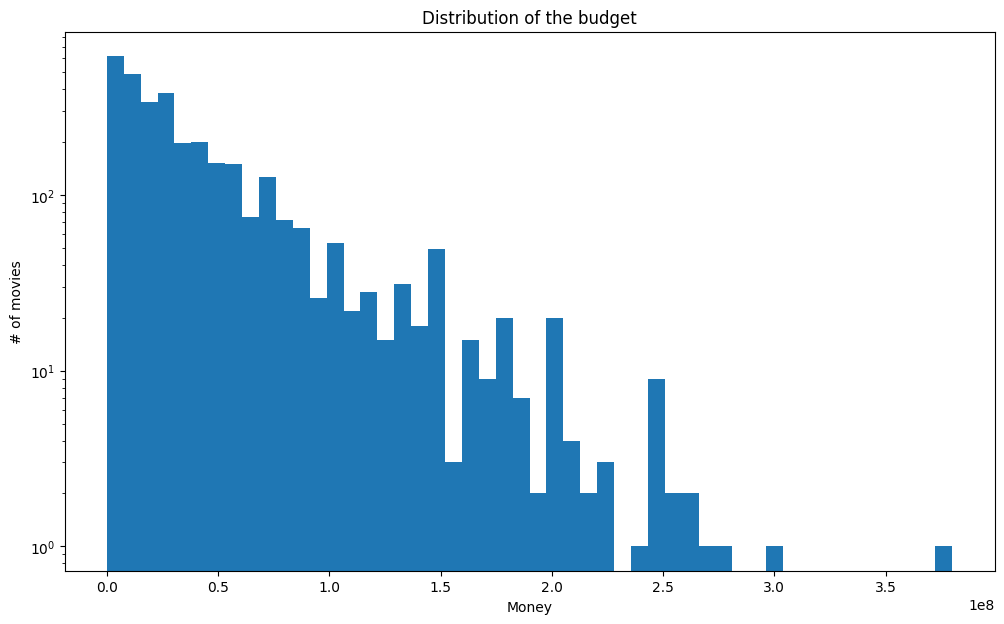

In [44]:
plt.figure(figsize=(12,7)) #  Movie Budget
plt.hist(movie_df['budget'],bins= 50)
plt.title("Distribution of the budget")
plt.xlabel('Money')
plt.ylabel('# of movies')
plt.yscale("log")
plt.show()

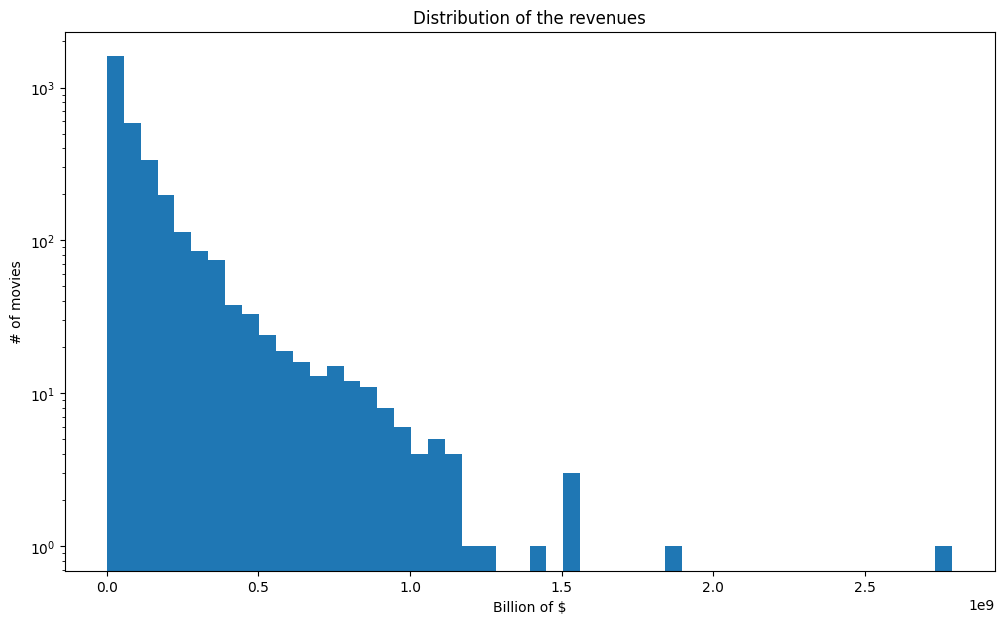

In [45]:
plt.figure(figsize=(12,7)) #Movie Revenue
plt.hist(movie_df['revenue'], bins= 50)
plt.title("Distribution of the revenues")
plt.xlabel('Billion of $')
plt.ylabel('# of movies')
plt.yscale("log")
plt.show()

In [46]:
df_genres = movie_df.explode('genres')
df_genres.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,year,month,day_of_year
0,237000000,Action,http://www.avatarmovie.com/,19995,"[culture clash, future, space war, space colon...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[Ingenious Film Partners, Twentieth Century Fo...",...,162.0,"[English, Español]",Released,Enter the World of Pandora.,Avatar,7.2,11800,2009,12,344
0,237000000,Adventure,http://www.avatarmovie.com/,19995,"[culture clash, future, space war, space colon...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[Ingenious Film Partners, Twentieth Century Fo...",...,162.0,"[English, Español]",Released,Enter the World of Pandora.,Avatar,7.2,11800,2009,12,344
0,237000000,Fantasy,http://www.avatarmovie.com/,19995,"[culture clash, future, space war, space colon...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[Ingenious Film Partners, Twentieth Century Fo...",...,162.0,"[English, Español]",Released,Enter the World of Pandora.,Avatar,7.2,11800,2009,12,344
0,237000000,Science Fiction,http://www.avatarmovie.com/,19995,"[culture clash, future, space war, space colon...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[Ingenious Film Partners, Twentieth Century Fo...",...,162.0,"[English, Español]",Released,Enter the World of Pandora.,Avatar,7.2,11800,2009,12,344
1,300000000,Adventure,http://disney.go.com/disneypictures/pirates/,285,"[ocean, drug abuse, exotic island, east india ...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[Walt Disney Pictures, Jerry Bruckheimer Films...",...,169.0,[English],Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,2007,5,139


In [47]:
df_genres.genres.unique()

array(['Action', 'Adventure', 'Fantasy', 'Science Fiction', 'Crime',
       'Drama', 'Thriller', 'Animation', 'Family', 'Western', 'Comedy',
       'Romance', 'Horror', 'Mystery', 'History', 'War', 'Music',
       'Documentary', 'Foreign', nan], dtype=object)

In [48]:
count_genres = df_genres.groupby('genres')['id'].count().reset_index(name='movie_count')
count_genres = count_genres.sort_values(by='movie_count', ascending=False)

count_genres.head()

,genres,movie_count
6,Drama,1428
3,Comedy,1101
16,Thriller,930
0,Action,915
1,Adventure,660


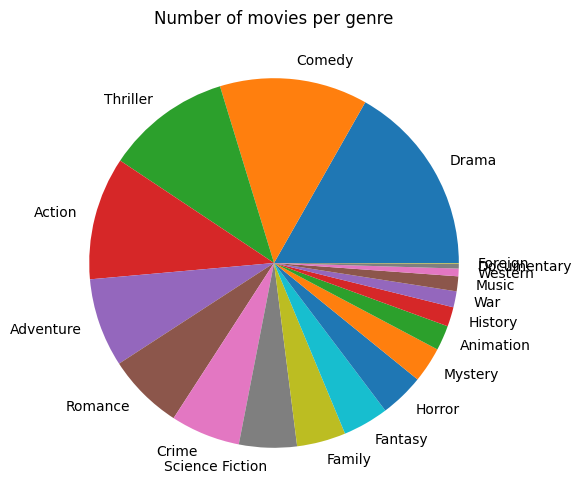

In [49]:
count_genres.set_index('genres')['movie_count'].plot(kind='pie', figsize=(10,6), legend=False)
plt.title('Number of movies per genre')
plt.ylabel('')
plt.show()

In [50]:
df_genres_revenue = movie_df[['genres','revenue']].explode('genres') #What genre make the most money
df_genres_revenue.head()

,genres,revenue
0,Action,2787965087
0,Adventure,2787965087
0,Fantasy,2787965087
0,Science Fiction,2787965087
1,Adventure,961000000


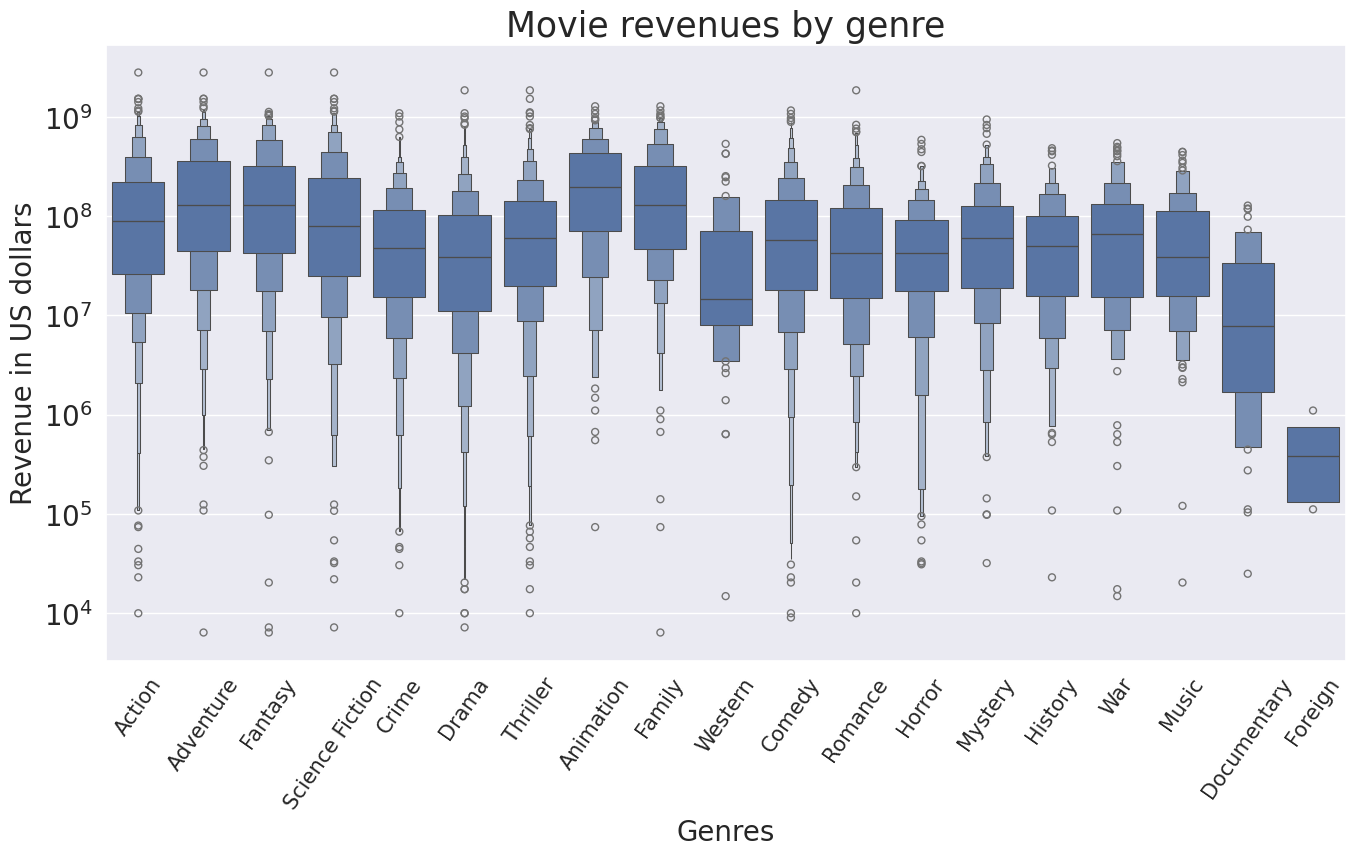

In [51]:
sns.set(style="darkgrid")
f,ax=plt.subplots(figsize=(16, 8))
sns.boxenplot(data=df_genres_revenue[df_genres_revenue["revenue"]>0].reset_index(),x="genres",y="revenue")
plt.yticks(fontsize=20)
plt.yscale("log")
plt.xticks(rotation=55,fontsize=15)
plt.xlabel("Genres",fontsize=20)
plt.ylabel("Revenue in US dollars",fontsize=20)
plt.title("Movie revenues by genre",fontsize=25)
plt.show()

In [52]:
df_genres_revenue = df_genres_revenue.groupby('genres')[['revenue']].sum()
df_genres_revenue.head()

,revenue
genres,
Action,162316088206
Adventure,163667924225
Animation,52436463168
Comedy,120403594524
Crime,45797218000


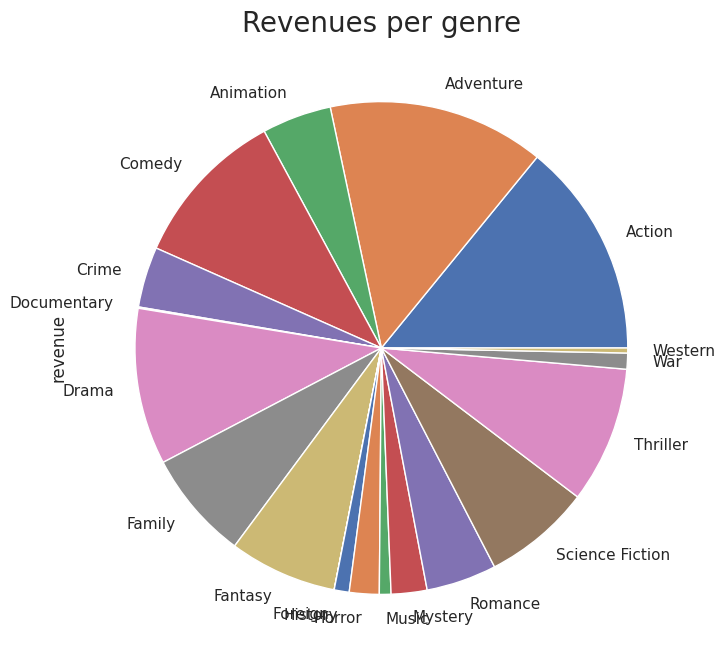

In [53]:
df_genres_revenue.plot(kind ='pie',figsize=(16,8),legend = False, subplots = True)
plt.title('Revenues per genre',fontsize=20)
plt.show()

In [54]:
df_genres_grade = movie_df[['genres','vote_average']].explode('genres')
df_genres_grade.head()

,genres,vote_average
0,Action,7.2
0,Adventure,7.2
0,Fantasy,7.2
0,Science Fiction,7.2
1,Adventure,6.9


In [55]:
df_genres_grade.shape

(8509, 2)

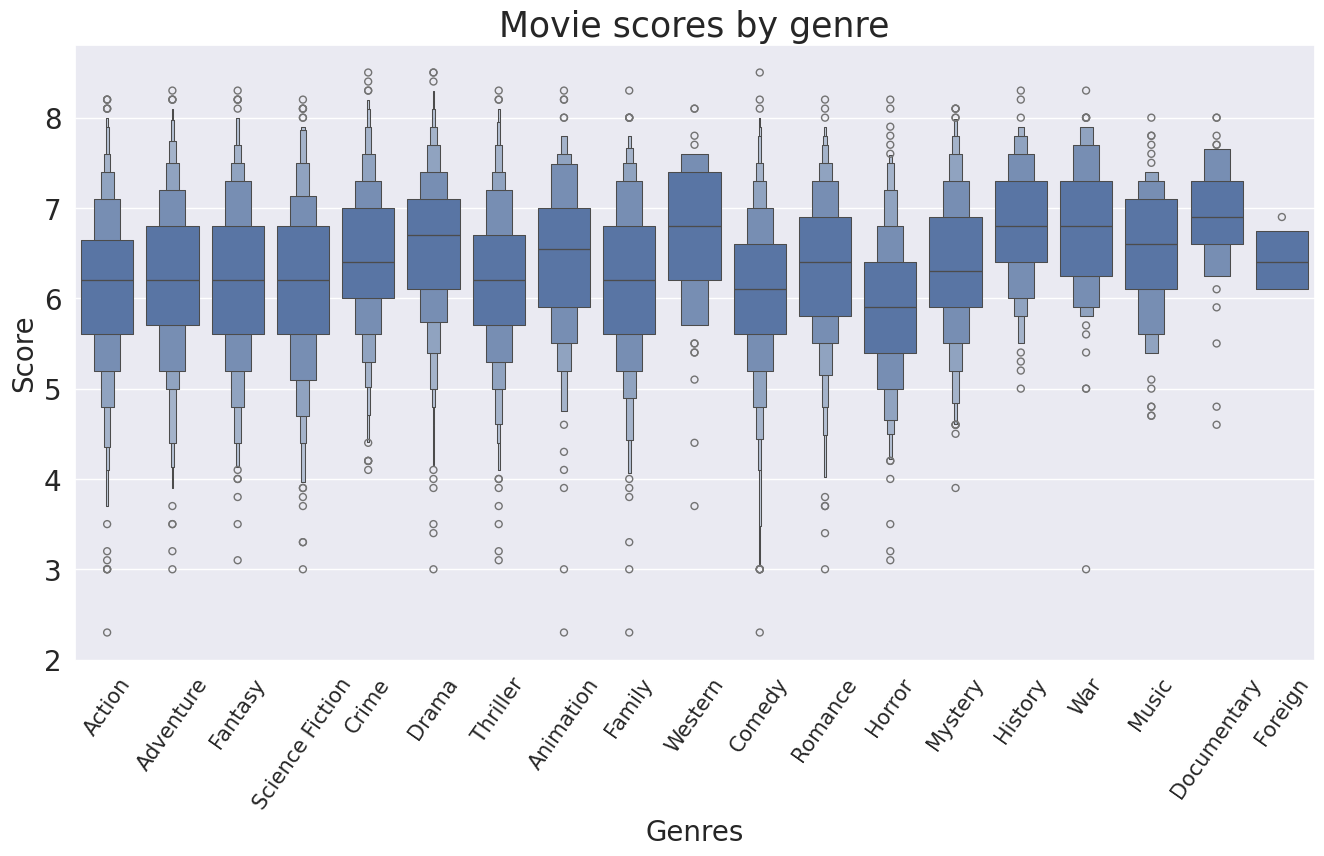

In [56]:
sns.set(style="darkgrid")
f,ax=plt.subplots(figsize=(16, 8))
sns.boxenplot(data=df_genres_grade.reset_index(drop=True),x="genres",y="vote_average")
plt.yticks(fontsize=20)
plt.xticks(rotation=55,fontsize=15)
plt.xlabel("Genres",fontsize=20)
plt.ylabel("Score",fontsize=20)
plt.title("Movie scores by genre",fontsize=25)
plt.show()

In [57]:
df_movie_pop = movie_df[['title','popularity']].sort_values(by='popularity', ascending=False)
df_movie_pop.head()

,title,popularity
546,Minions,875.581305
95,Interstellar,724.247784
788,Deadpool,514.569956
94,Guardians of the Galaxy,481.098624
127,Mad Max: Fury Road,434.278564


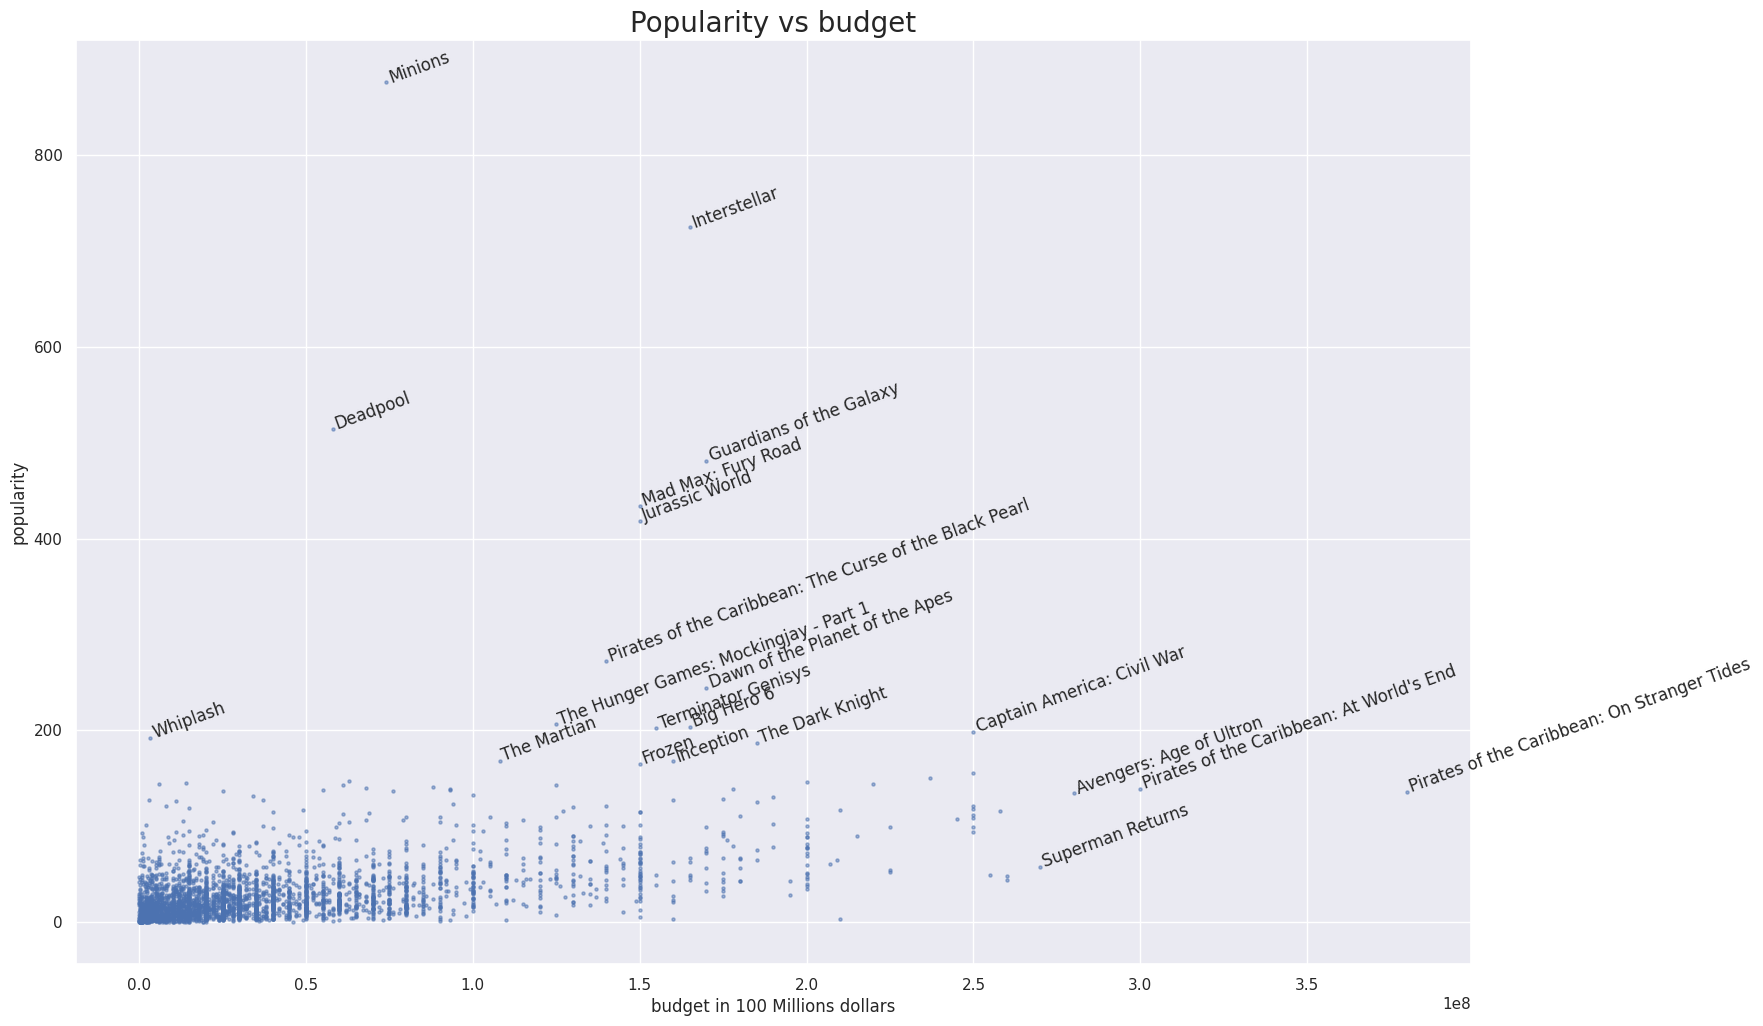

In [58]:
x=movie_df["budget"]
y=movie_df["popularity"]
fig,ax=plt.subplots(figsize=(18,12))
plt.scatter(x,y,alpha=0.5,s=5)
plt.title("Popularity vs budget",fontsize=20)
plt.xlabel("budget in 100 Millions dollars")
plt.ylabel("popularity")
for index , row in movie_df.iterrows():
    x=row["budget"]
    y=row["popularity"]
    if((500000000>x>260000000) | (y>160)):
        plt.annotate(row["title"],xy=(x,y),rotation=20)

In [59]:
df_movie_revenue = movie_df[['title','revenue','release_date']].set_index('release_date').sort_values(by='revenue', ascending=False) #Revenue Timeline
df_movie_revenue.head()

,title,revenue
release_date,,
2009-12-10,Avatar,2787965087
1997-11-18,Titanic,1845034188
2012-04-25,The Avengers,1519557910
2015-06-09,Jurassic World,1513528810
2015-04-01,Furious 7,1506249360


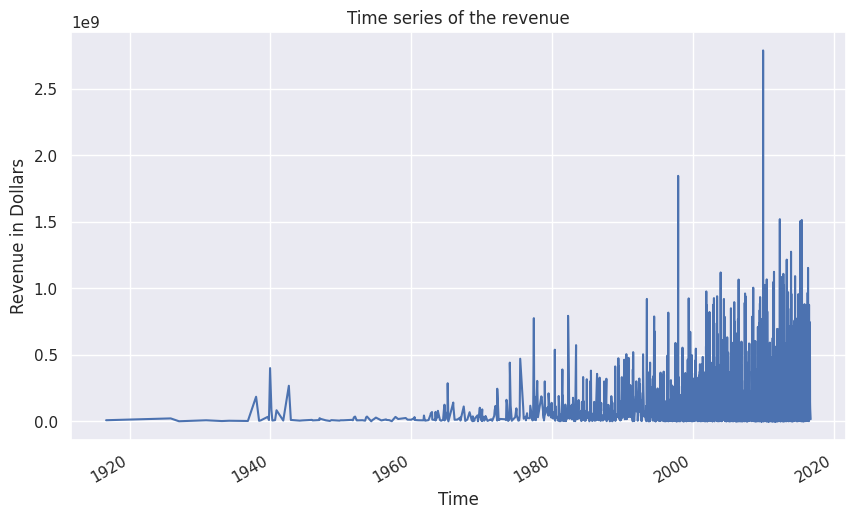

In [60]:
df_movie_revenue.sort_index().plot(figsize=(10,6),legend = False)
plt.title('Time series of the revenue')
plt.xlabel("Time")
plt.ylabel("Revenue in Dollars")
plt.show()

In [61]:
df_genres_revenue_year = movie_df[['genres','revenue','year']].explode('genres').groupby(['genres','year']).sum()
df_genres_revenue_year.head()

revenue
genres year          
Action 1930   8000000
       1936   2736000
       1949   7800000
       1950   8000000
       1952  36000000

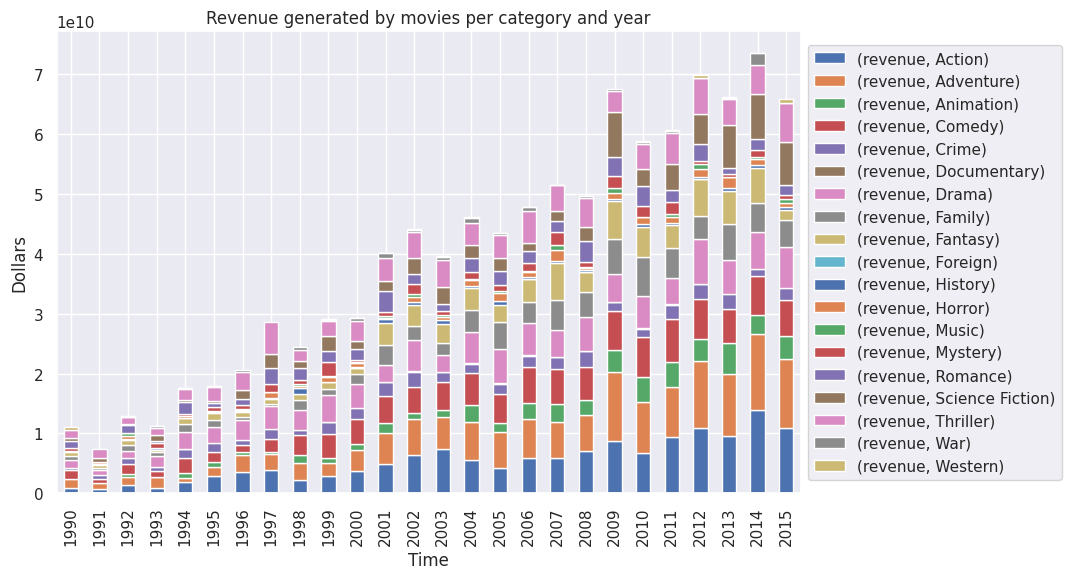

In [62]:
fig = plt.figure()
ax = plt.subplot(111)

starting_year = 1990
df_genres_revenue_year = movie_df[['genres','revenue','year']].explode('genres').groupby(['genres','year']).sum()
df_genres_revenue_year.unstack(level=0).fillna(0).loc[starting_year:2015].plot(kind = 'bar',stacked=True, ax=ax, figsize=(12,6),legend  = True)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Revenue generated by movies per category and year')
plt.ylabel('Dollars')
plt.xlabel('Time')
plt.show()

In [63]:
movie_df.year.describe()

,year
count,3209.000000
mean,2001.722032
std,13.198112
min,1916.000000
25%,1998.000000
50%,2005.000000
75%,2010.000000
max,2016.000000


In [64]:
credits_df.head() #Actors

,movie_id,title,cast,crew
0,19995,Avatar,"[[Sam Worthington, 2], [Zoe Saldana, 1], [Sigo...","[[Stephen E. Rivkin, Editor, Editing, 0], [Ric..."
1,285,Pirates of the Caribbean: At World's End,"[[Johnny Depp, 2], [Orlando Bloom, 2], [Keira ...","[[Dariusz Wolski, Director of Photography, Cam..."
2,206647,Spectre,"[[Daniel Craig, 2], [Christoph Waltz, 2], [Léa...","[[Thomas Newman, Original Music Composer, Soun..."
3,49026,The Dark Knight Rises,"[[Christian Bale, 2], [Michael Caine, 2], [Gar...","[[Hans Zimmer, Original Music Composer, Sound,..."
4,49529,John Carter,"[[Taylor Kitsch, 2], [Lynn Collins, 1], [Saman...","[[Andrew Stanton, Screenplay, Writing, 2], [An..."


In [65]:
df_actors = credits_df.set_index('title').cast.apply(pd.Series).stack().reset_index(level= 0).rename(columns={0:'cast'})
df_actors.head()

,title,cast
0,Avatar,"[Sam Worthington, 2]"
1,Avatar,"[Zoe Saldana, 1]"
2,Avatar,"[Sigourney Weaver, 1]"
3,Avatar,"[Stephen Lang, 2]"
4,Avatar,"[Michelle Rodriguez, 1]"


In [66]:
df_actors['actor'] = df_actors['cast'].map(lambda x: x[0])
df_actors['actor_gender']  = df_actors['cast'].map(lambda x: x[1])
df_actors.drop(columns = 'cast',inplace = True)
df_actors.head()

,title,actor,actor_gender
0,Avatar,Sam Worthington,2
1,Avatar,Zoe Saldana,1
2,Avatar,Sigourney Weaver,1
3,Avatar,Stephen Lang,2
4,Avatar,Michelle Rodriguez,1


In [67]:
df_actors.actor.nunique()

54201

In [68]:
df_actor_movie = df_actors.merge(movie_df, on='title', how='left').dropna()
df_actor_movie.head()

,title,actor,actor_gender,budget,genres,homepage,id,keywords,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,vote_average,vote_count,year,month,day_of_year
0,Avatar,Sam Worthington,2,237000000.0,"[Action, Adventure, Fantasy, Science Fiction]",http://www.avatarmovie.com/,19995.0,"[culture clash, future, space war, space colon...",en,Avatar,...,2.787965e+09,162.0,"[English, Español]",Released,Enter the World of Pandora.,7.2,11800.0,2009.0,12.0,344.0
1,Avatar,Zoe Saldana,1,237000000.0,"[Action, Adventure, Fantasy, Science Fiction]",http://www.avatarmovie.com/,19995.0,"[culture clash, future, space war, space colon...",en,Avatar,...,2.787965e+09,162.0,"[English, Español]",Released,Enter the World of Pandora.,7.2,11800.0,2009.0,12.0,344.0
2,Avatar,Sigourney Weaver,1,237000000.0,"[Action, Adventure, Fantasy, Science Fiction]",http://www.avatarmovie.com/,19995.0,"[culture clash, future, space war, space colon...",en,Avatar,...,2.787965e+09,162.0,"[English, Español]",Released,Enter the World of Pandora.,7.2,11800.0,2009.0,12.0,344.0
3,Avatar,Stephen Lang,2,237000000.0,"[Action, Adventure, Fantasy, Science Fiction]",http://www.avatarmovie.com/,19995.0,"[culture clash, future, space war, space colon...",en,Avatar,...,2.787965e+09,162.0,"[English, Español]",Released,Enter the World of Pandora.,7.2,11800.0,2009.0,12.0,344.0
4,Avatar,Michelle Rodriguez,1,237000000.0,"[Action, Adventure, Fantasy, Science Fiction]",http://www.avatarmovie.com/,19995.0,"[culture clash, future, space war, space colon...",en,Avatar,...,2.787965e+09,162.0,"[English, Español]",Released,Enter the World of Pandora.,7.2,11800.0,2009.0,12.0,344.0


Text(0, 0.5, 'Mean revenue in Billion dollars')

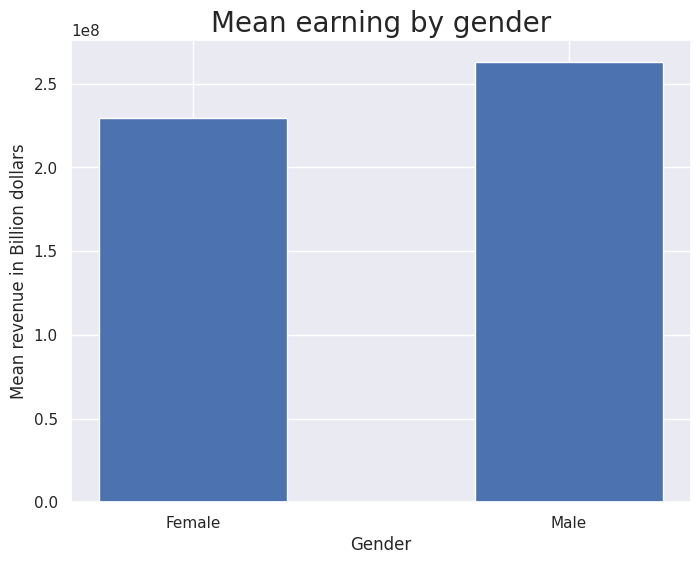

In [69]:
gender_plot=df_actor_movie.groupby('actor_gender')[['revenue']].mean()[1:]
f,ax=plt.subplots(figsize=(8,6))
plt.bar(["Female","Male"],gender_plot["revenue"],width=0.5)
plt.title("Mean earning by gender",fontsize=20)
plt.xlabel("Gender")
plt.ylabel("Mean revenue in Billion dollars")

In [70]:
gender_plot

,revenue
actor_gender,
1,2.295606e+08
2,2.628484e+08


In [71]:
gender_plot=df_actor_movie.groupby(['actor_gender',"year"])[['revenue']].mean()
gender_plot.unstack(level=0).fillna(0)

revenue                            
actor_gender             0             1             2
year                                                  
1937.0        1.849255e+08  1.849255e+08  1.849255e+08
1939.0        3.375497e+07  3.375497e+07  3.375497e+07
1940.0        8.332000e+07  0.000000e+00  8.332000e+07
1942.0        2.674472e+08  2.674472e+08  2.674472e+08
1962.0        5.960000e+07  5.960000e+07  5.960000e+07
1963.0        7.889876e+07  7.889876e+07  7.889876e+07
1964.0        8.394237e+07  1.061175e+08  8.266304e+07
1965.0        0.000000e+00  1.411957e+08  1.411957e+08
1966.0        6.000000e+06  0.000000e+00  6.000000e+06
1967.0        1.115848e+08  1.115848e+08  1.115848e+08
1969.0        8.197449e+07  8.197449e+07  8.197449e+07
1970.0        4.000000e+07  4.000000e+07  4.000000e+07
1971.0        4.400558e+07  1.160195e+08  9.361520e+07
1972.0        2.450664e+08  2.450664e+08  2.450664e+08
1973.0        3.015420e+08  3.481300e+08  2.922244e+08
1974.0        9.757200e+07  9.757200e+07  9.757200e+07
1975.0        2.711004e+08  2.637095e+08  3.063157e+08
1977.0        7.192114e+08  4.066734e+08  6.094719e+08
1978.0        1.165172e+08  1.055000e+08  1.154400e+08
1979.0        1.476165e+08  1.376245e+08  1.178747e+08
1980.0        4.493423e+08  1.563794e+08  4.013709e+08
1981.0        2.610155e+08  1.451146e+08  1.976007e+08
1982.0        5.385278e+08  3.180537e+08  9.026184e+07
1983.0        3.825669e+08  2.414255e+08  2.977633e+08
1984.0        2.768319e+08  1.147467e+08  2.198316e+08
1985.0        2.251980e+08  2.432205e+08  2.722498e+08
1986.0        1.100000e+07  1.100000e+07  1.100000e+07
1987.0        1.707770e+08  1.274082e+08  1.080927e+08
1988.0        8.187281e+06  1.079368e+07  1.098822e+07
1989.0        3.567475e+08  2.554880e+08  2.970196e+08
1990.0        1.374454e+08  1.663010e+08  1.792960e+08
1991.0        7.434726e+06  7.434726e+06  7.434726e+06
1992.0        1.909815e+08  3.079510e+08  2.575578e+08
1993.0        3.424594e+08  2.248870e+08  5.511368e+08
1994.0        2.626244e+08  3.558316e+08  3.823998e+08
1995.0        2.531791e+08  1.783503e+08  2.088363e+08
1996.0        1.911339e+08  1.165967e+08  1.551782e+08
1997.0        7.853158e+08  7.688350e+08  6.173689e+08
1998.0        8.029016e+07  1.592071e+08  9.493575e+07
1999.0        2.803258e+08  2.377576e+08  2.453274e+08
2000.0        1.118620e+08  1.105699e+08  1.307231e+08
2001.0        3.774534e+08  3.005035e+08  3.232307e+08
2002.0        2.763334e+08  2.728733e+08  2.990508e+08
2003.0        2.635343e+08  1.987132e+08  2.633589e+08
2004.0        2.429115e+08  2.030079e+08  2.325863e+08
2005.0        2.639256e+08  1.679993e+08  2.214672e+08
2006.0        2.068760e+08  1.364788e+08  1.935160e+08
2007.0        2.655684e+08  2.411973e+08  2.484655e+08
2008.0        2.814613e+08  1.741627e+08  2.074447e+08
2009.0        2.982783e+08  2.269196e+08  2.345395e+08
2010.0        1.785022e+08  1.811904e+08  1.888115e+08
2011.0        1.631113e+08  1.430320e+08  1.933340e+08
2012.0        3.265101e+08  2.575735e+08  3.680976e+08
2013.0        3.458771e+08  3.369184e+08  3.180494e+08
2014.0        3.101392e+08  3.006918e+08  3.826671e+08
2015.0        3.136056e+08  3.254035e+08  3.294777e+08
2016.0        3.231625e+08  2.886579e+08  3.303914e+08

In [72]:
df_actor_movie_count = df_actor_movie.groupby('actor')[['id']].count().sort_values(by ='id',ascending = False)
df_actor_movie_count.columns=["count"]
df_actor_movie_count.head()

,count
actor,
Samuel L. Jackson,29
Matt Damon,26
Morgan Freeman,23
Bill Hader,23
Jonah Hill,22


In [73]:
df_nb_actors = df_actors.groupby('title')[['actor']].count().sort_values(by='actor',ascending = False)
df_nb_actors.rename(columns={"actor": "# of actors"},inplace = True)
df_nb_actors.head(10)

,# of actors
title,
Rock of Ages,224
Mr. Smith Goes to Washington,213
Les Misérables,208
Jason Bourne,208
You Don't Mess with the Zohan,183
Real Steel,172
Star Trek,168
Oz: The Great and Powerful,159
The Dark Knight Rises,158


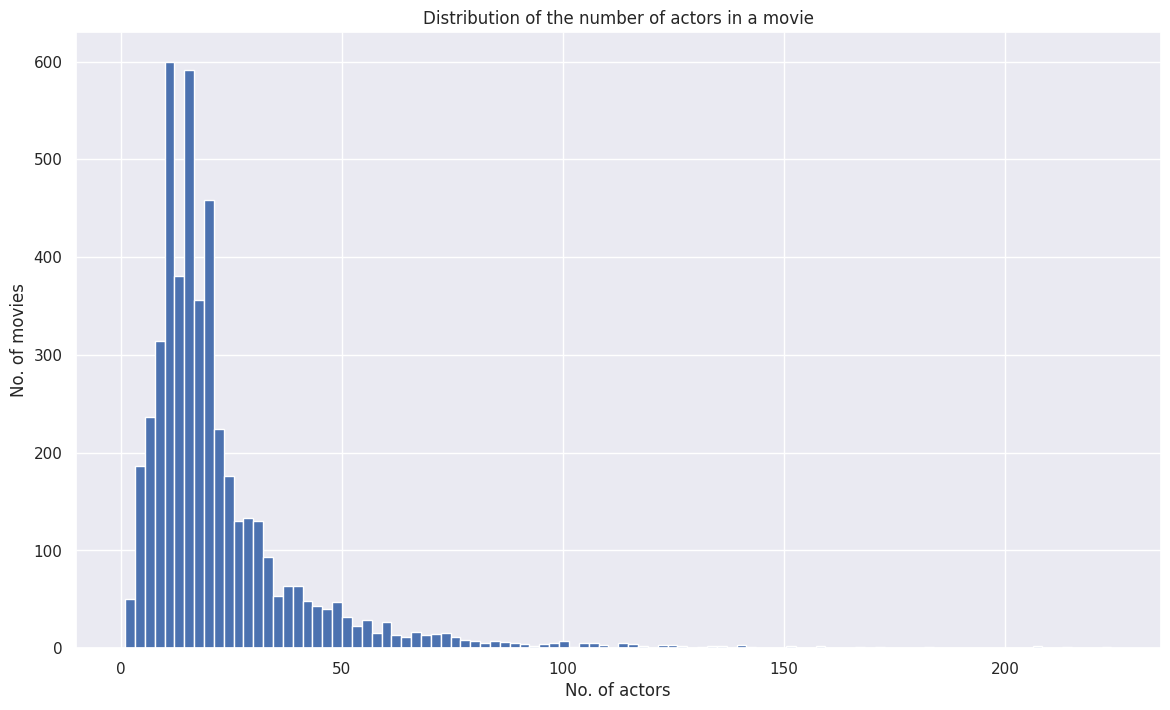

In [74]:
plt.figure(figsize=(14,8))
plt.hist(df_nb_actors['# of actors'],100)
plt.title('Distribution of the number of actors in a movie')
plt.ylabel('No. of movies')
plt.xlabel('No. of actors')
plt.show()

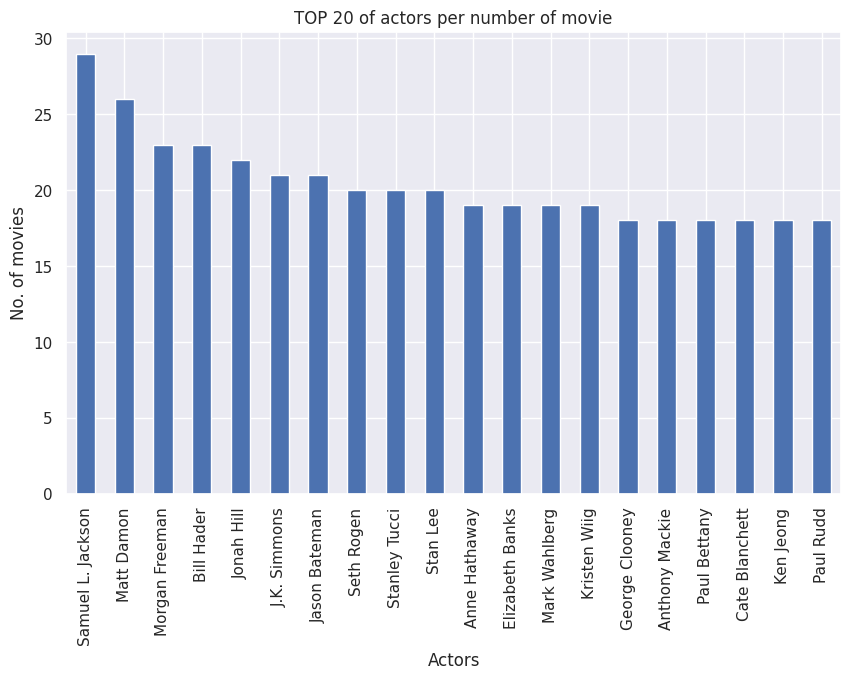

In [75]:
df_actor_movie_count[:20].plot(kind ="bar",figsize=(10,6),legend = False)
plt.title('TOP 20 of actors per number of movie')
plt.ylabel("No. of movies")
plt.xlabel("Actors")
plt.show()

In [76]:
df_actor_revenue_sum = df_actor_movie.groupby('actor')[['revenue']].sum().sort_values(by ='revenue',ascending = False)
df_actor_revenue_sum.head()

,revenue
actor,
Stan Lee,1.590812e+10
Samuel L. Jackson,1.253272e+10
Frank Welker,9.815289e+09
Hugo Weaving,9.335319e+09
Cate Blanchett,8.923467e+09


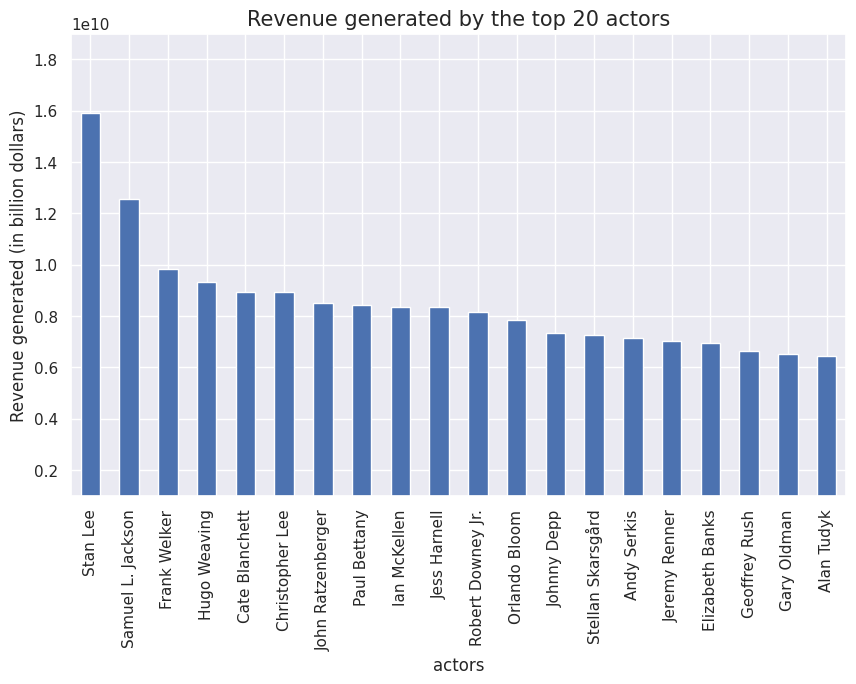

In [77]:
df_actor_revenue_sum[:20].plot(kind ="bar",figsize=(10,6),legend = False)

plt.title('Revenue generated by the top 20 actors',fontsize=15)
plt.ylabel("Revenue generated (in billion dollars)")
plt.xlabel("actors")
plt.ylim(1e9,1e10+9e9)
plt.show()

In [78]:
df_actor_vote = df_actor_movie.groupby('actor')[['vote_average']].mean().sort_values(by ='vote_average',ascending = False)
df_actor_vote.head()

,vote_average
actor,
Joe Lo Grippo,8.4
Joe Spinell,8.4
Carmine Coppola,8.4
Nick Vallelonga,8.4
Sal Richards,8.4


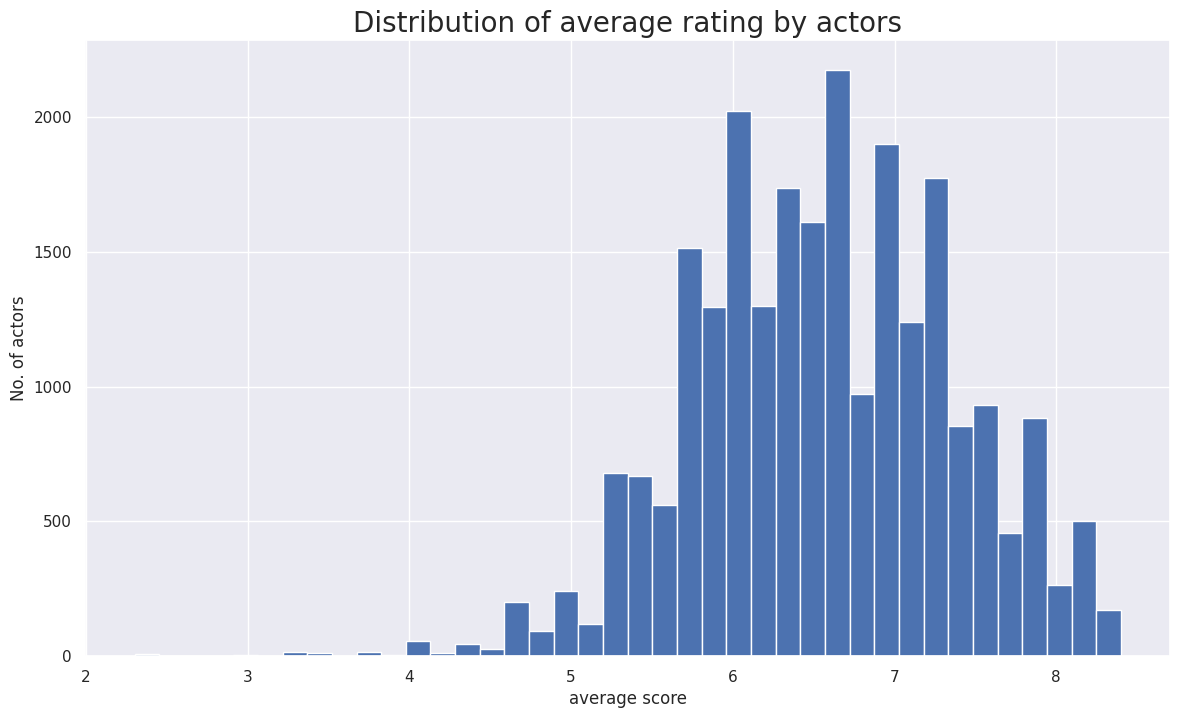

In [79]:
plt.figure(figsize=(14,8))
plt.hist(df_actor_vote['vote_average'],40)
plt.title('Distribution of average rating by actors',fontsize=20)
plt.xlabel('average score')
plt.ylabel('No. of actors')
plt.show()

In [80]:
df_actor_movie['actor_gender'].value_counts() #The industry is dominated by men

,count
actor_gender,
2,16330
0,13083
1,8326


In [81]:
actors_top500 = df_actor_movie_count.head(500).index.values #selecting top 500actors for ML model

ML MODEL

In [82]:
movie_df.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count', 'year', 'month', 'day_of_year'],
      dtype='object')

In [83]:
features_kept = ['title','keywords','budget','genres','popularity', 'production_companies',
                'production_countries', 'year' ,'day_of_year','month','revenue', 'runtime', 'spoken_languages',
                'vote_average', 'vote_count',]

data = movie_df[features_kept].set_index('title')
data=data[data["year"]>1960]
data.head()

,keywords,budget,genres,popularity,production_companies,production_countries,year,day_of_year,month,revenue,runtime,spoken_languages,vote_average,vote_count
title,,,,,,,,,,,,,,
Avatar,"[culture clash, future, space war, space colon...",237000000,"[Action, Adventure, Fantasy, Science Fiction]",150.437577,"[Ingenious Film Partners, Twentieth Century Fo...","[United States of America, United Kingdom]",2009,344,12,2787965087,162.0,"[English, Español]",7.2,11800
Pirates of the Caribbean: At World's End,"[ocean, drug abuse, exotic island, east india ...",300000000,"[Adventure, Fantasy, Action]",139.082615,"[Walt Disney Pictures, Jerry Bruckheimer Films...",[United States of America],2007,139,5,961000000,169.0,[English],6.9,4500
Spectre,"[spy, based on novel, secret agent, sequel, mi...",245000000,"[Action, Adventure, Crime]",107.376788,"[Columbia Pictures, Danjaq, B24]","[United Kingdom, United States of America]",2015,299,10,880674609,148.0,"[Français, English, Español, Italiano, Deutsch]",6.3,4466
The Dark Knight Rises,"[dc comics, crime fighter, terrorist, secret i...",250000000,"[Action, Crime, Drama, Thriller]",112.312950,"[Legendary Pictures, Warner Bros., DC Entertai...",[United States of America],2012,198,7,1084939099,165.0,[English],7.6,9106
John Carter,"[based on novel, mars, medallion, space travel...",260000000,"[Action, Adventure, Science Fiction]",43.926995,[Walt Disney Pictures],[United States of America],2012,67,3,284139100,132.0,[English],6.1,2124


In [84]:
data.shape

(3145, 14)

In [85]:
features_kept = ['title','keywords','budget','genres','popularity', 'production_companies',
                'production_countries', 'year' ,'day_of_year','month','revenue', 'runtime', 'spoken_languages',
                'vote_average', 'vote_count',]

data = movie_df[features_kept].set_index('title')
data=data[data["year"]>1960]

col_to_explode = ['genres','keywords','production_companies','production_countries','spoken_languages']

for c in col_to_explode:
    data_exploded = data.explode(c)

    dummies = pd.get_dummies(data_exploded[c], prefix=c).reset_index().groupby('title').sum()

    data = dummies.join(data)

    data.drop(columns = c, inplace=True)

data.head()

,spoken_languages_,spoken_languages_Afrikaans,spoken_languages_Bahasa indonesia,spoken_languages_Bosanski,spoken_languages_Català,spoken_languages_Cymraeg,spoken_languages_Dansk,spoken_languages_Deutsch,spoken_languages_Eesti,spoken_languages_English,...,genres_Western,budget,popularity,year,day_of_year,month,revenue,runtime,vote_average,vote_count
title,,,,,,,,,,,,,,,,,,,,,
(500) Days of Summer,0,0,0,0,0,0,0,0,0,1,...,0,7500000,45.610993,2009,198,7,60722734,95.0,7.2,2904
10 Cloverfield Lane,0,0,0,0,0,0,0,0,0,1,...,0,15000000,53.698683,2016,70,3,108286421,103.0,6.8,2468
10 Things I Hate About You,0,0,0,0,0,0,0,0,0,1,...,0,16000000,54.550275,1999,89,3,53478166,97.0,7.3,1701
102 Dalmatians,0,0,0,0,0,0,0,0,0,1,...,0,85000000,9.895061,2000,281,10,183611771,100.0,5.1,313
10th & Wolf,0,0,0,0,0,0,0,0,0,1,...,0,8000000,3.942464,2006,50,2,143451,107.0,6.3,24


In [86]:
data_no_cast=data.copy()
print("data_no_cast created with shape:", data_no_cast.shape)

data_no_cast created with shape: (3145, 12185)


In [87]:
# Revenue Prediction - Linear Regression

In [88]:
seed=2006
split_size=0.2

def preprocess(data,y_col,x_to_drop,seed=seed,split_size=split_size):

    data.rename(columns = lambda x: x.replace(' ', '_'), inplace=True)
    y=data[y_col]
    X=data.drop(columns=x_to_drop)
    X = sm.add_constant(X, has_constant='add') # Adding a constant column
    scaler = StandardScaler()
    X_transformed = scaler.fit_transform(X)
    X = pd.DataFrame(X_transformed, columns = X.columns,index=y.index)

    return train_test_split(X, y, test_size=split_size, random_state=seed)

def adjusted_r_2(y_test,y_pred,n,p):
    r2=r2_score(y_test,y_pred)
    return 1-(1-r2)*(n-1)/(n-p-1)

X_train, X_test, y_train, y_test = preprocess(data_no_cast, "revenue", ["revenue", "vote_count", "vote_average", "popularity"])

ridge_model = RidgeCV(alphas=np.logspace(-6, 6, 13))

ridge_model.fit(X_train, y_train)

y_pred = ridge_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

n_train = len(y_train)
p_train = X_train.shape[1]
adj_r2 = adjusted_r_2(y_test, y_pred, n_train, p_train)

print("RidgeCV model trained successfully.")
print(f"Mean Squared Error: {mse}")
print(f"Adjusted R-squared: {adj_r2}")

RidgeCV model trained successfully.
Mean Squared Error: 1.841649817620071e+16
Adjusted R-squared: 1.128830429628624


In [89]:
#Revenue Prediction - XGBoost Regressor

In [90]:
xgb_model = XGBRegressor(random_state=seed)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
adj_r2_xgb = adjusted_r_2(y_test, y_pred_xgb, len(y_train), X_train.shape[1])

print("XGBoost Regressor Model Trained Successfully.")
print(f"Mean Squared Error (XGBoost): {mse_xgb}")
print(f"Adjusted R-squared (XGBoost): {adj_r2_xgb}")

XGBoost Regressor Model Trained Successfully.
Mean Squared Error (XGBoost): 1.3308320165134336e+16
Adjusted R-squared (XGBoost): 1.0930967781774825


In [91]:
# Prepare Data for Success Rate Prediction

In [92]:
success_threshold = data_no_cast['revenue'].quantile(0.75)
print(f"Success revenue threshold (75th percentile): {success_threshold}")

Success revenue threshold (75th percentile): 149673788.0


In [93]:
data_no_cast['is_successful'] = (data_no_cast['revenue'] >= success_threshold).astype(int)
print("Added 'is_successful' column to data_no_cast DataFrame.")
print(data_no_cast[['revenue', 'is_successful']].head())

Added 'is_successful' column to data_no_cast DataFrame.
                              revenue  is_successful
title                                               
(500) Days of Summer         60722734              0
10 Cloverfield Lane         108286421              0
10 Things I Hate About You   53478166              0
102 Dalmatians              183611771              1
10th & Wolf                    143451              0


In [94]:
X_train_clf, X_test_clf, y_train_clf, y_test_clf = preprocess(data_no_cast, "is_successful", ["is_successful", "revenue", "vote_count", "vote_average"])

print("Data preprocessed for classification models.")
print(f"Shape of X_train_clf: {X_train_clf.shape}")
print(f"Shape of y_train_clf: {y_train_clf.shape}")
print(f"Shape of X_test_clf: {X_test_clf.shape}")
print(f"Shape of y_test_clf: {y_test_clf.shape}")

Data preprocessed for classification models.
Shape of X_train_clf: (2516, 12183)
Shape of y_train_clf: (2516,)
Shape of X_test_clf: (629, 12183)
Shape of y_test_clf: (629,)


In [95]:
#Success Rate Prediction - Logistic Regression

In [96]:
log_reg_model = LogisticRegression(random_state=seed, max_iter=1000)

log_reg_model.fit(X_train_clf, y_train_clf)

y_pred_lr = log_reg_model.predict(X_test_clf)

accuracy_lr = accuracy_score(y_test_clf, y_pred_lr)
precision_lr = precision_score(y_test_clf, y_pred_lr)
recall_lr = recall_score(y_test_clf, y_pred_lr)
f1_lr = f1_score(y_test_clf, y_pred_lr)

print("Logistic Regression Model Trained Successfully.")
print(f"Accuracy: {accuracy_lr:.4f}")
print(f"Precision: {precision_lr:.4f}")
print(f"Recall: {recall_lr:.4f}")
print(f"F1-Score: {f1_lr:.4f}")

Logistic Regression Model Trained Successfully.
Accuracy: 0.7297
Precision: 0.4549
Recall: 0.7114
F1-Score: 0.5550


In [97]:
#Success Rate Prediction - XGBoost Classifier

In [98]:
xgb_clf_model = XGBClassifier(random_state=seed, use_label_encoder=False, eval_metric='logloss')

xgb_clf_model.fit(X_train_clf, y_train_clf)

y_pred_xgb_clf = xgb_clf_model.predict(X_test_clf)

accuracy_xgb_clf = accuracy_score(y_test_clf, y_pred_xgb_clf)
precision_xgb_clf = precision_score(y_test_clf, y_pred_xgb_clf)
recall_xgb_clf = recall_score(y_test_clf, y_pred_xgb_clf)
f1_xgb_clf = f1_score(y_test_clf, y_pred_xgb_clf)

print("XGBoost Classifier Model Trained Successfully.")
print(f"Accuracy (XGBoost): {accuracy_xgb_clf:.4f}")
print(f"Precision (XGBoost): {precision_xgb_clf:.4f}")
print(f"Recall (XGBoost): {recall_xgb_clf:.4f}")
print(f"F1-Score (XGBoost): {f1_xgb_clf:.4f}")

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [09:52:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Classifier Model Trained Successfully.
Accuracy (XGBoost): 0.8808
Precision (XGBoost): 0.7681
Recall (XGBoost): 0.7114
F1-Score (XGBoost): 0.7387


In [99]:
xgb_clf_model = XGBClassifier(random_state=seed, eval_metric='logloss')

xgb_clf_model.fit(X_train_clf, y_train_clf)

y_pred_xgb_clf = xgb_clf_model.predict(X_test_clf)

accuracy_xgb_clf = accuracy_score(y_test_clf, y_pred_xgb_clf)
precision_xgb_clf = precision_score(y_test_clf, y_pred_xgb_clf)
recall_xgb_clf = recall_score(y_test_clf, y_pred_xgb_clf)
f1_xgb_clf = f1_score(y_test_clf, y_pred_xgb_clf)

print("XGBoost Classifier Model Trained Successfully.")
print(f"Accuracy (XGBoost): {accuracy_xgb_clf:.4f}")
print(f"Precision (XGBoost): {precision_xgb_clf:.4f}")
print(f"Recall (XGBoost): {recall_xgb_clf:.4f}")
print(f"F1-Score (XGBoost): {f1_xgb_clf:.4f}")

XGBoost Classifier Model Trained Successfully.
Accuracy (XGBoost): 0.8808
Precision (XGBoost): 0.7681
Recall (XGBoost): 0.7114
F1-Score (XGBoost): 0.7387


In [100]:
#Analyze and Visualize Model Results

In [101]:
metrics_data = {
    'Model': ['RidgeCV Regression', 'XGBoost Regressor', 'Logistic Regression', 'XGBoost Classifier'],
    'MSE': [mse, mse_xgb, None, None],
    'Adjusted R-squared': [adj_r2, adj_r2_xgb, None, None],
    'Accuracy': [None, None, accuracy_lr, accuracy_xgb_clf],
    'Precision': [None, None, precision_lr, precision_xgb_clf],
    'Recall': [None, None, recall_lr, recall_xgb_clf],
    'F1-score': [None, None, f1_lr, f1_xgb_clf]
}

metrics_df = pd.DataFrame(metrics_data)

print("Evaluation metrics stored in DataFrame.")

Evaluation metrics stored in DataFrame.


In [102]:
print("Comparison of Model Performance:")
print(metrics_df.to_string())

Comparison of Model Performance:
                 Model           MSE  Adjusted R-squared  Accuracy  Precision    Recall  F1-score
0   RidgeCV Regression  1.841650e+16            1.128830       NaN        NaN       NaN       NaN
1    XGBoost Regressor  1.330832e+16            1.093097       NaN        NaN       NaN       NaN
2  Logistic Regression           NaN                 NaN  0.729730   0.454936  0.711409  0.554974
3   XGBoost Classifier           NaN                 NaN  0.880763   0.768116  0.711409  0.738676


In [103]:
print("Comparison of Model Performance:")
display(metrics_df)

Comparison of Model Performance:


,Model,MSE,Adjusted R-squared,Accuracy,Precision,Recall,F1-score
0,RidgeCV Regression,1.841650e+16,1.128830,NaN,NaN,NaN,NaN
1,XGBoost Regressor,1.330832e+16,1.093097,NaN,NaN,NaN,NaN
2,Logistic Regression,NaN,NaN,0.729730,0.454936,0.711409,0.554974
3,XGBoost Classifier,NaN,NaN,0.880763,0.768116,0.711409,0.738676


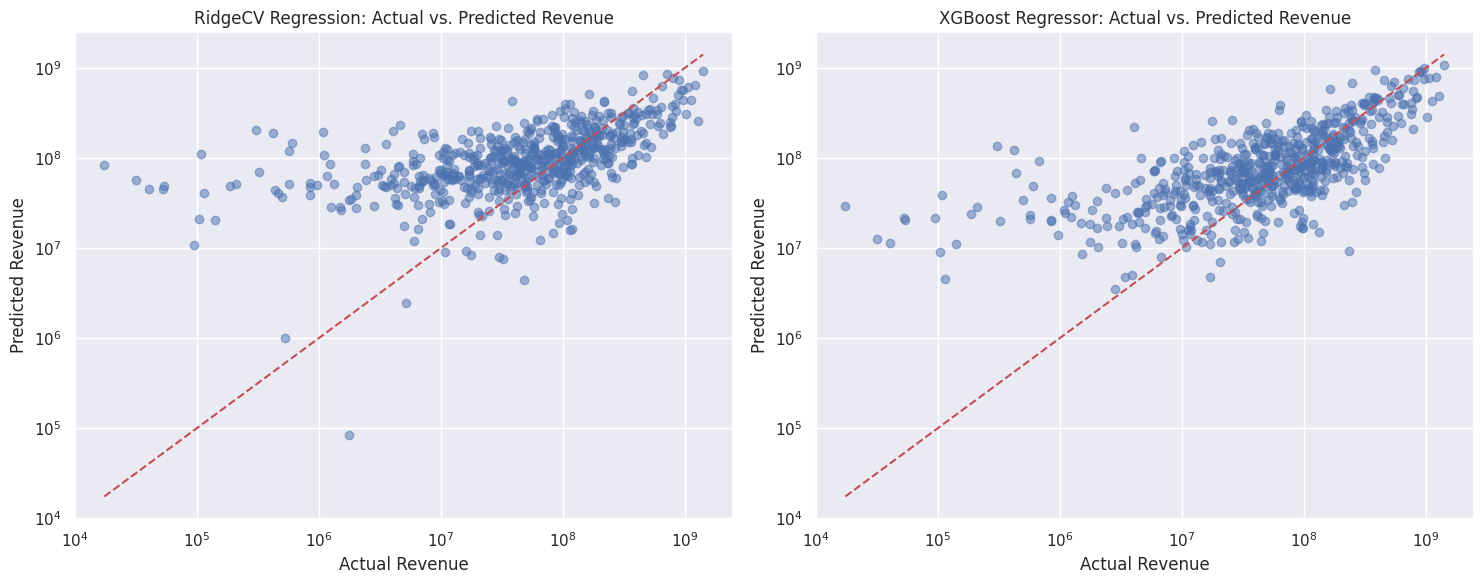

In [104]:
plt.figure(figsize=(15, 6))

# Plot for RidgeCV Regression
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Revenue')
plt.ylabel('Predicted Revenue')
plt.title('RidgeCV Regression: Actual vs. Predicted Revenue')
plt.xscale('log')
plt.yscale('log')

# Plot for XGBoost Regressor
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_xgb, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Revenue')
plt.ylabel('Predicted Revenue')
plt.title('XGBoost Regressor: Actual vs. Predicted Revenue')
plt.xscale('log')
plt.yscale('log')

plt.tight_layout()
plt.show()

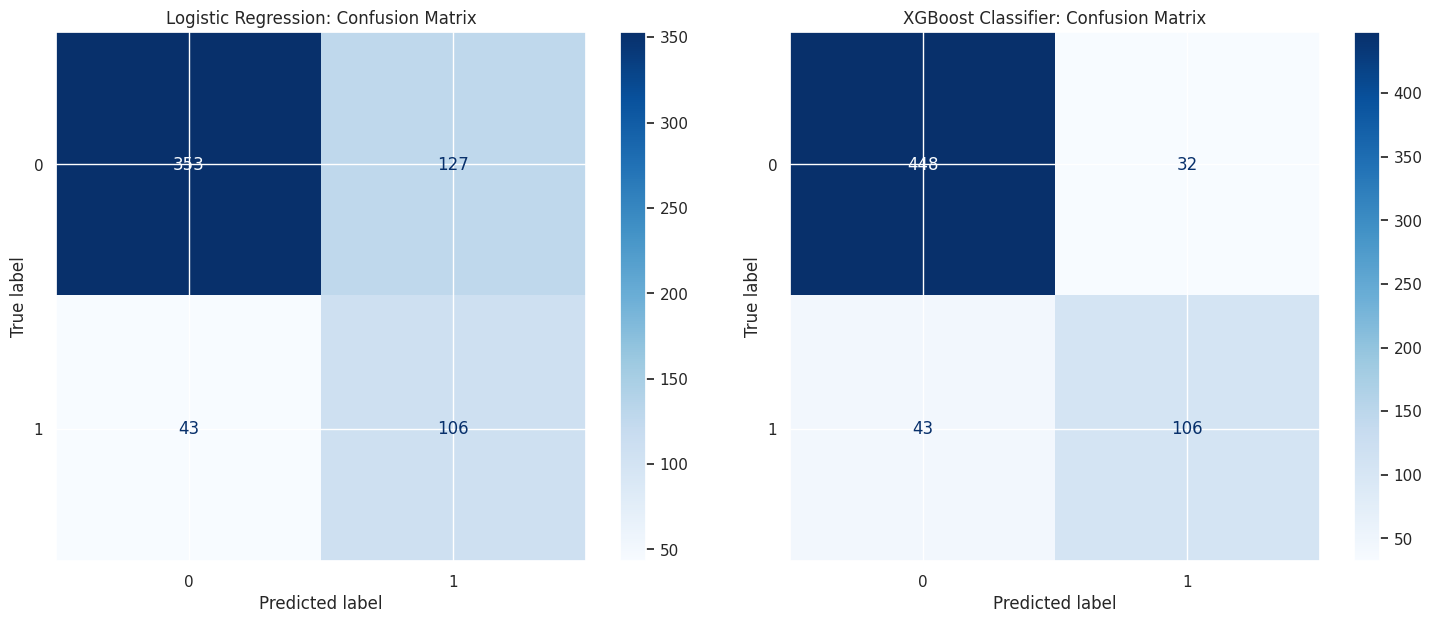

In [105]:
plt.figure(figsize=(15, 6))

# Plot for Logistic Regression Confusion Matrix
plt.subplot(1, 2, 1)
cm_lr = confusion_matrix(y_test_clf, y_pred_lr)
display_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr)
display_lr.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title('Logistic Regression: Confusion Matrix')

# Plot for XGBoost Classifier Confusion Matrix
plt.subplot(1, 2, 2)
cm_xgb_clf = confusion_matrix(y_test_clf, y_pred_xgb_clf)
display_xgb_clf = ConfusionMatrixDisplay(confusion_matrix=cm_xgb_clf)
display_xgb_clf.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title('XGBoost Classifier: Confusion Matrix')

plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

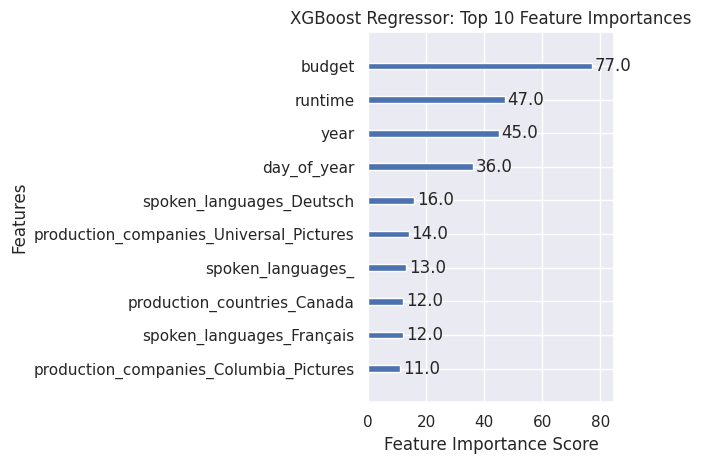

In [106]:
plt.figure(figsize=(12, 8))
plot_importance(xgb_model, max_num_features=10)
plt.title('XGBoost Regressor: Top 10 Feature Importances')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

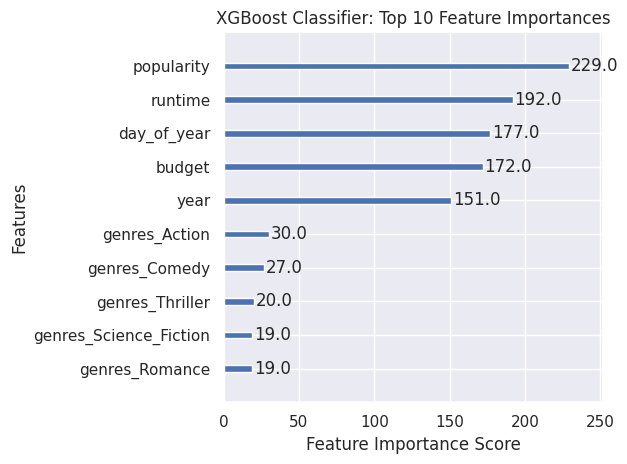

In [107]:
plt.figure(figsize=(12, 8))
plot_importance(xgb_clf_model, max_num_features=10)
plt.title('XGBoost Classifier: Top 10 Feature Importances')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [108]:
#THE_END